# Linear Regression + Ridge/Lasso/ElasticNet ML (startup dataset)

## Objective:
Build a predictive and explainable ML model that helps investors or founders understand:

“Which area of spend has the greatest return on investment in early-stage startups?”

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [107]:
df = pd.read_csv('50_Startups_dataset.csv')

### 1. Data Preprocessing

In [108]:
df.columns

Index(['Unnamed: 0', 'R&D Spend', 'Administration', 'Marketing Spend', 'State',
       'Profit'],
      dtype='object')

In [109]:
df.head()

,Unnamed: 0,R&D Spend,Administration,Marketing Spend,State,Profit
0,0,165349.30,136897.90,471784.20,New York,192261.93
1,1,162597.80,151377.69,443898.63,California,191792.16
2,2,153441.61,101145.65,407934.64,Florida,191050.49
3,3,144372.51,118671.95,383199.72,New York,182902.09
4,4,142107.44,91391.87,366168.52,Florida,166188.04


In [110]:
df.isnull().sum()

Unnamed: 0         0
R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [111]:
df.drop('Unnamed: 0', axis=1, inplace=True)


In [112]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.30,136897.90,471784.20,New York,192261.93
1,162597.80,151377.69,443898.63,California,191792.16
2,153441.61,101145.65,407934.64,Florida,191050.49
3,144372.51,118671.95,383199.72,New York,182902.09
4,142107.44,91391.87,366168.52,Florida,166188.04


In [113]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Perform one-hot encoding on the cleaned 'State' column
encoded_array = encoder.fit_transform(df[['State']])  # Must be a 2D input
print(encoded_array.shape)  # Should be (number of rows, number of unique states)

# Convert the array to a DataFrame with proper column names
encoded_State = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(['State'])
)

# Ensure the indices of the encoded DataFrame match the original
encoded_State.index = df.index

# Join with the original DataFrame
df = df.join(encoded_State)


(50, 3)


In [114]:
df.head()


,R&D Spend,Administration,Marketing Spend,State,Profit,State_California,State_Florida,State_New York
0,165349.30,136897.90,471784.20,New York,192261.93,0.0,0.0,1.0
1,162597.80,151377.69,443898.63,California,191792.16,1.0,0.0,0.0
2,153441.61,101145.65,407934.64,Florida,191050.49,0.0,1.0,0.0
3,144372.51,118671.95,383199.72,New York,182902.09,0.0,0.0,1.0
4,142107.44,91391.87,366168.52,Florida,166188.04,0.0,1.0,0.0


In [115]:
df.columns.str.strip()
df.rename(columns={'State_New York': 'State_New_York'}, inplace=True)
df.drop('State', axis=1,inplace=True)

In [116]:

df['State_California']=df.State_California.astype(int)
df['State_Florida']=df.State_Florida.astype(int)
df['State_New_York']=df.State_New_York.astype(int)

### 2. Exploratory Data Analysis

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R&D Spend         50 non-null     float64
 1   Administration    50 non-null     float64
 2   Marketing Spend   50 non-null     float64
 3   Profit            50 non-null     float64
 4   State_California  50 non-null     int64  
 5   State_Florida     50 non-null     int64  
 6   State_New_York    50 non-null     int64  
dtypes: float64(4), int64(3)
memory usage: 2.9 KB


Text(0.5, 1.0, 'Correlation Matrix')

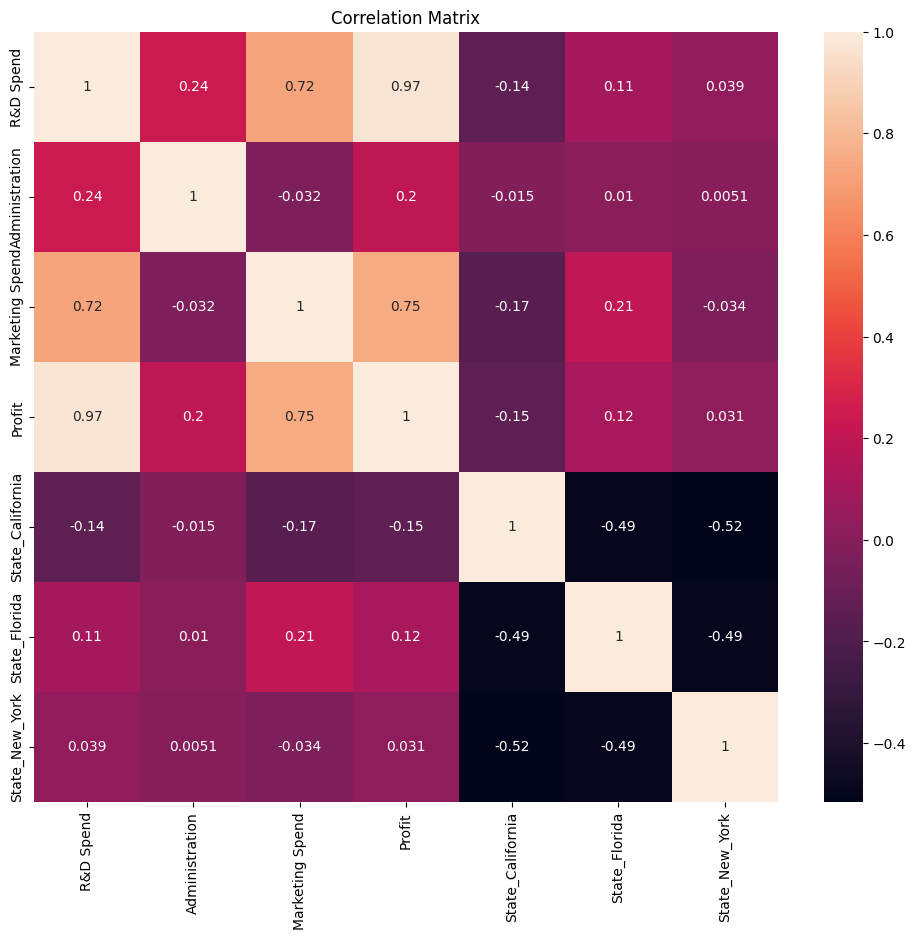

In [118]:
## Checking for Multicollinearity 
corr_matrix = df.corr()
corr_matrix

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')

In [119]:
df.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit',
       'State_California', 'State_Florida', 'State_New_York'],
      dtype='object')

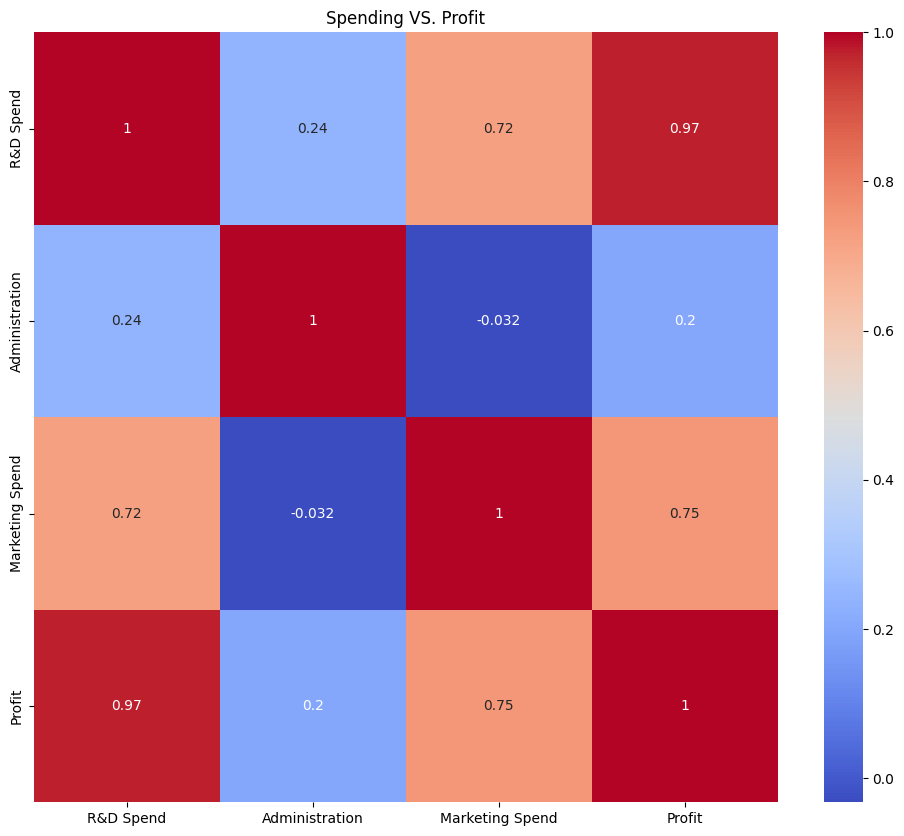

In [120]:
## Feature correlations with profit



features_comparison = ['R&D Spend', 'Administration', 'Marketing Spend']
target_feature = 'Profit'
selected_features = features_comparison + [target_feature]
correlation = df[selected_features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True)
plt.title('Spending VS. Profit')
plt.show()

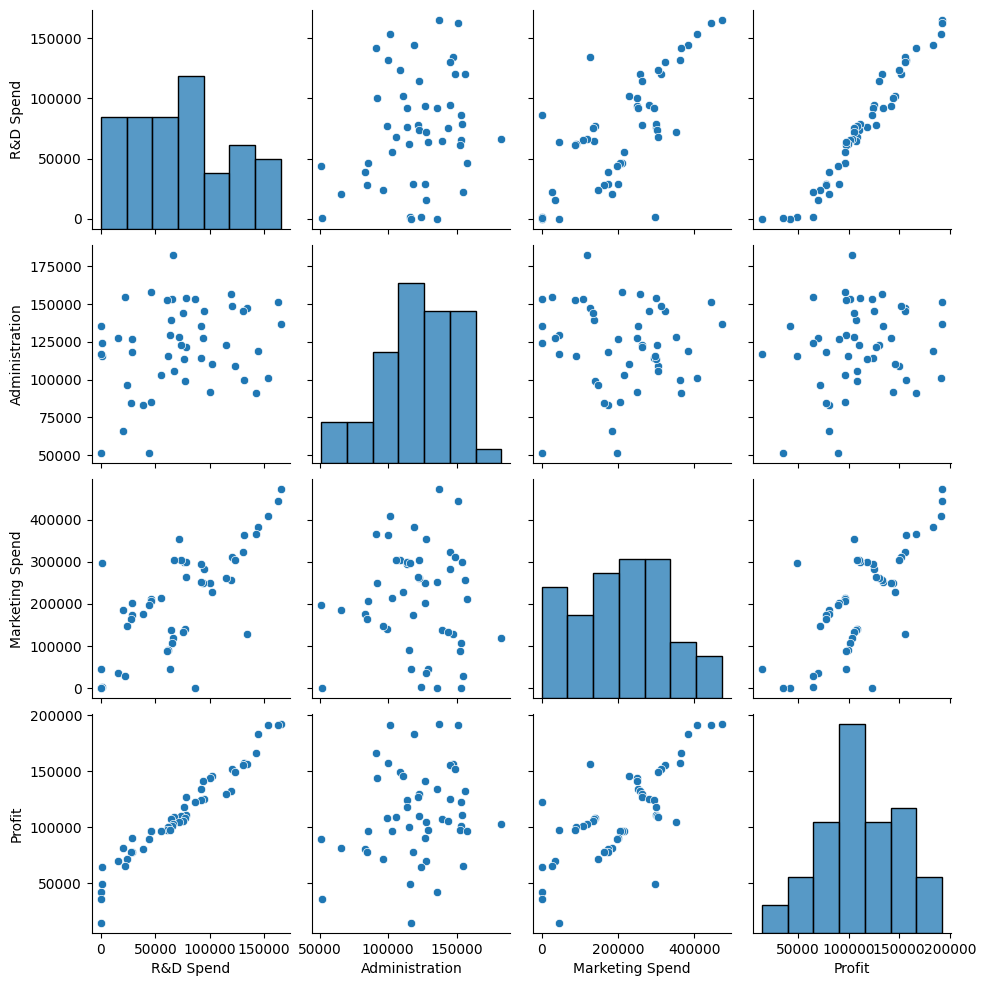

In [121]:
d_features = df[selected_features]
sns.pairplot(d_features)

C:\Users\mssam\AppData\Local\Temp\ipykernel_9420\4171162046.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_profit_by_state, x=state_features, y=target_feature, palette='viridis')


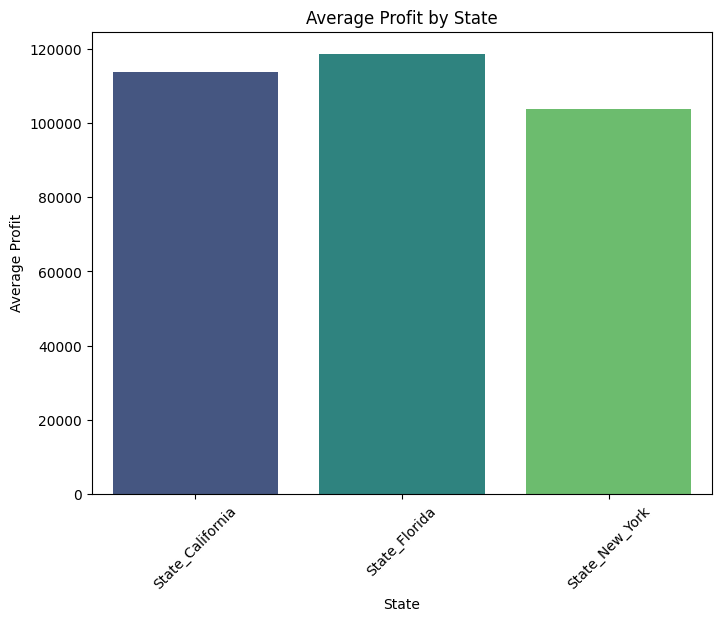

In [122]:
state_features = ['State_California', 'State_Florida', 'State_New_York']
target_feature = 'Profit'
# Calculate the average profit for each state
average_profit_by_state = df.groupby(state_features)[target_feature].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=average_profit_by_state, x=state_features, y=target_feature, palette='viridis')
plt.title('Average Profit by State')
plt.ylabel('Average Profit')
plt.xlabel('State')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### 3. Modeling Phase 1 -- Linear Regression

In [123]:
from sklearn.model_selection import train_test_split

X = df.drop('Profit', axis=1)
y = df['Profit']
X.head()


,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New_York
0,165349.30,136897.90,471784.20,0,0,1
1,162597.80,151377.69,443898.63,1,0,0
2,153441.61,101145.65,407934.64,0,1,0
3,144372.51,118671.95,383199.72,0,0,1
4,142107.44,91391.87,366168.52,0,1,0


In [124]:
y.head()

0    192261.93
1    191792.16
2    191050.49
3    182902.09
4    166188.04
Name: Profit, dtype: float64

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [126]:
## Standardization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)
print('RMSE: ', root_mean_squared_error(y_pred, y_test))
print('MAE: ', mean_absolute_error(y_pred, y_test))
print('R^2: ', r2_score(y_pred, y_test))


RMSE:  7635.03195520574
MAE:  5049.814453673169
R^2:  0.9680668727146736


### 4. Modeling Phase 2 -- Regularized Models

In [128]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred1 = ridge.predict(X_test)
print('RMSE: ', root_mean_squared_error(y_pred1, y_test))
print('MAE: ', mean_absolute_error(y_pred1, y_test))
print('R^2: ', r2_score(y_pred1, y_test))


RMSE:  7142.634891167163
MAE:  4597.999949758301
R^2:  0.971331491584903


In [129]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred2= lasso.predict(X_test)
print('RMSE: ', root_mean_squared_error(y_pred2, y_test))
print('MAE: ', mean_absolute_error(y_pred2, y_test))
print('R^2: ', r2_score(y_pred2, y_test))


RMSE:  7634.744511167331
MAE:  5050.112111515626
R^2:  0.9680696505292454


In [130]:
elastic = ElasticNet()
elastic.fit(X_train, y_train)
y_pred3 = elastic.predict(X_test)
print('RMSE: ', root_mean_squared_error(y_pred3, y_test))
print('MAE: ', mean_absolute_error(y_pred3, y_test))
print('R^2: ', r2_score(y_pred3, y_test))


RMSE:  7028.780045562216
MAE:  5152.885206857472
R^2:  0.9550191630262426


In [ ]:
from sklearn.svm import SVR

# Initialize SVR
svr = svm.SVR()

# Define parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'linear']
}

# Perform grid search
grid = GridSearchCV(svr, param_grid=param_grid, refit=True, cv=3, verbose=2)
grid.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters:", grid.best_params_)



In [136]:


## Prediction
y_pred4=grid.predict(X_test)
print('RMSE: ', root_mean_squared_error(y_pred4, y_test))
print('MAE: ', mean_absolute_error(y_pred4, y_test))
print('R^2: ', r2_score(y_pred4, y_test))

RMSE:  17145.20331805587
MAE:  10203.97740255238
R^2:  0.8843048485420788


In [140]:
df.columns


Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit',
       'State_California', 'State_Florida', 'State_New_York'],
      dtype='object')

### 5. Model Insights & Interpretation

From the comparison between profit vs spending, R&D (0.97) has the most effect on profit followed by marketing (0.75) and administration (0.2) based on correlation matrix.

Florida State has the highest Average profit of around $120,000 followed by California and NYC.

We get the best R^2 SCORE of around 97%  using Ridge, much better than when using even grid or other metrics

In [141]:
from joblib import dump

dump(ridge, 'ridge.pkl')
dump(lasso, 'lasso.pkl')
dump(elastic, 'elastic.pkl')
dump(linear_regression, 'linear_regression.pkl')
dump(scaler, 'scaler.pkl')

['scaler.pkl']